# Reinforcement Learning: CartPole DQN Solution

In [1]:
import gym
import numpy as np
import random
import math

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
class RingBuffer():
    def __init__(self, size):
        self.size = size
        self.buffer_ar = []
        for i in range(0, size):
            self.buffer_ar.append(0)
        self.counter = 0
        self.full = False
    
    def add(self, value):
        self.buffer_ar[self.counter] = value
        self.counter += 1
        if self.counter > self.size-1:
            self.counter = 0
            self.full = True
    
    def get_random(self, last_n, sample_size):
        if not self.full:
            last_n = self.counter
        if self.counter - last_n < 0:
            end = np.linspace(self.counter-last_n, -1, -1*(self.counter-last_n))
            start = np.linspace(0, self.counter-1, self.counter)
            window = np.concatenate((end, start))
        else:
            window = np.linspace(self.counter-last_n, self.counter-1, last_n)
            #print(window)
        random_index = np.random.choice(a=window, size=sample_size, replace=False)
        random_choices = []
        for i in random_index:
            random_choices.append(self.buffer_ar[int(i)])
        return random_choices
    
    def __repr__(self):
        return str(self.buffer_ar)

In [4]:
def epsilon_by_frame(frame_idx):
    #return 0
    epsilon_start = 1.0
    epsilon_final = 0.01
    epsilon_decay = 500
    return epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

def plot(frame, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.title("frame %s. reward: %s" % (frame, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [5]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)
        
    def forward(self, states):
        #print(states)
        out = F.relu(self.fc1(states))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        #print(out)
        return out

In [6]:
dqn = DQN()

In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(dqn.parameters())

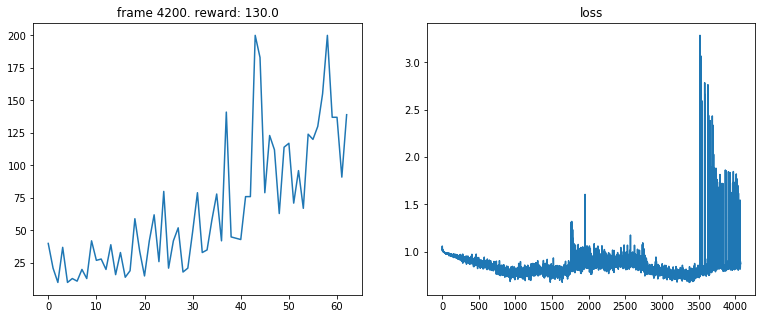

In [ ]:
memory_buffer = RingBuffer(1000)
learn_counter = 0
gamma = 1.0
frame = 0
all_rewards = []
all_losses = []
env = gym.make('CartPole-v0')

for episode in range(2000):
    observation = env.reset()
    env.render()
    lifespan = []
    counter = 0
    
    while True:
        frame += 1
        counter += 1
        env.render()
        
        optimizer.zero_grad()
        
        epsilon = epsilon_by_frame(frame)
        if random.random() > epsilon:
            observation_tensor = torch.tensor([observation], dtype=torch.float)
            output = dqn(observation_tensor)
            action = torch.argmax(output, dim=1).item()
        else:
            action = env.action_space.sample()
            
        next_observation, reward, done, info = env.step(action)
        memory_buffer.add([observation, action, reward, next_observation, done])
        
        learn_counter += 1
        if learn_counter >= 128:
            samples = memory_buffer.get_random(1000, 128)
            s_0 = []
            actions = []
            rewards = []
            s_1 = []
            done_ar = []
            for sample in samples:
                s_0.append(sample[0])
                actions.append(sample[1])
                rewards.append(sample[2])
                s_1.append(sample[3])
                done_ar.append(sample[4])
            
            s_0_tensor = torch.tensor(s_0, dtype=torch.float)
            s_0_output = dqn(s_0_tensor)
            s_0_output = s_0_output[range(0, 128), actions]
            
            s_1_tensor = torch.tensor(s_1, dtype=torch.float)
            s_1_output = dqn(s_1_tensor)
            s_1_output = torch.max(s_1_output, dim=1).values
            s_1_output = gamma * s_1_output
            
            rewards = torch.tensor(rewards, dtype=torch.float)
            
            done_ar = torch.tensor(done_ar, dtype=torch.float)
            
            error = rewards + (s_1_output * (1-done_ar)) - s_0_output
            loss = torch.pow(error, 2)
            loss = torch.mean(loss)
            all_losses.append(loss.item())
            
            loss.backward()
            optimizer.step()
        
        observation = next_observation.copy()
        
        if done:
            break
            
        if frame % 200 == 0:
            plot(frame, all_rewards, all_losses)
            
    lifespan.append(counter)
    all_rewards.append(counter)